In [2]:
import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

### Separate lymphs on slide

In [ ]:
# data_dir = '/ix3/djishnu/alw399/visiumHD_lymph/raw_data/CCL4_LNs/square_008um'
data_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/raw_data/CCL4_LNs/square_008um'

adata_st = sc.read_10x_mtx(f'{data_dir}/filtered_feature_bc_matrix')
spatial = pd.read_parquet(f'{data_dir}/spatial/tissue_positions.parquet')

barcodes = list(set(adata_st.obs_names) & set(spatial['barcode'].values))
adata_st = adata_st[barcodes, :]

spatial.set_index('barcode', inplace=True)
adata_st.obs = spatial.loc[barcodes]
adata_st.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[barcodes].values
adata_st

In [ ]:
import napari
viewer = napari.Viewer()

coords = adata_st.obsm['spatial']
spatial_coords = viewer.add_points(coords, size=10, face_color='blue', name='spatial')

In [ ]:
shape_4 = viewer.layers['ko_4']  
shape_3 = viewer.layers['ko_3']  
shape_2 = viewer.layers['ko_2']
shape_1 = viewer.layers['ko_1']

In [ ]:
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/ccl4_ko'
np.savez(
    f'{tmp_dir}/shapes_data.npz', 
    shape_4=shape_4.data, shape_3=shape_3.data, shape_2=shape_2.data, shape_1=shape_1.data
)

In [ ]:
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/ccl4_ko'

data = np.load(f'{tmp_dir}/shapes_data.npz')
coords = adata_st.obsm['spatial']

import easydict
shape_4 = easydict.EasyDict({'data': data['shape_4']})
shape_3 = easydict.EasyDict({'data': data['shape_3']})
shape_2 = easydict.EasyDict({'data': data['shape_2']})
shape_1 = easydict.EasyDict({'data': data['shape_1']})

In [ ]:
from shapely.geometry import Point, Polygon

def points_in_polygon(polygon_coords, points):
    polygon = Polygon(polygon_coords)
    return np.array([pt for pt in points if polygon.contains(Point(pt))])

adata_coords = {}

for i, polygon_coords in enumerate([shape_1.data, shape_2.data, shape_3.data, shape_4.data]):
    selected_points = points_in_polygon(polygon_coords[0], coords)
    adata_coords[i+1] = selected_points


In [ ]:
cell_lookup = pd.DataFrame(
    adata_st.obs_names, index=[f'{x}_{y}'for x, y in adata_st.obsm['spatial']])

adata_1_coords = [f'{x}_{y}' for x, y in adata_coords[1]]
adata_2_coords = [f'{x}_{y}' for x, y in adata_coords[2]]
adata_3_coords = [f'{x}_{y}' for x, y in adata_coords[3]]
adata_4_coords = [f'{x}_{y}' for x, y in adata_coords[4]]

adata_1 = adata_st[cell_lookup.loc[adata_1_coords].values.flatten(), :].copy()
adata_2 = adata_st[cell_lookup.loc[adata_2_coords].values.flatten(), :].copy()
adata_3 = adata_st[cell_lookup.loc[adata_3_coords].values.flatten(), :].copy()
adata_4 = adata_st[cell_lookup.loc[adata_4_coords].values.flatten(), :].copy()


In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(
    y=adata_st.obsm['spatial'][:, 0]*-1, x=adata_st.obsm['spatial'][:, 1], s=5, c='grey', label='All cells')
plt.scatter(
    y=adata_1.obsm['spatial'][:, 0]*-1, x=adata_1.obsm['spatial'][:, 1], s=5, c='red', label='Group 1')
plt.scatter(
    y=adata_2.obsm['spatial'][:, 0]*-1, x=adata_2.obsm['spatial'][:, 1], s=5, c='blue', label='Group 2')
plt.scatter(
    y=adata_3.obsm['spatial'][:, 0]*-1, x=adata_3.obsm['spatial'][:, 1], s=5, c='green', label='Group 3')
plt.scatter(
    y=adata_4.obsm['spatial'][:, 0]*-1, x=adata_4.obsm['spatial'][:, 1], s=5, c='purple', label='Group 4')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Separated Ccl4 KO lymph nodes')

In [ ]:
adata_1.write(f'{tmp_dir}/adata_1.h5ad')
adata_2.write(f'{tmp_dir}/adata_2.h5ad')
adata_3.write(f'{tmp_dir}/adata_3.h5ad')
adata_4.write(f'{tmp_dir}/adata_4.h5ad')

In [12]:
adata_1, adata_2, adata_3, adata_4

(AnnData object with n_obs × n_vars = 69869 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 68416 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 55615 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 22453 × 19059
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial')

### Run Tangram

In [108]:
# tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/ccl4_ko'
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/ccl4_ko'

sample = '4'
adata_st = sc.read_h5ad(f'{tmp_dir}/adata_{sample}.h5ad')
adata_st

AnnData object with n_obs × n_vars = 22453 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [109]:
sc.pp.filter_cells(adata_st, min_genes=100)
sc.pp.filter_genes(adata_st, min_cells=3)

In [110]:
mito_genes = adata_st.var_names.str.startswith('mt-')
adata_st.obs['percent_mito'] = np.sum(
    adata_st[:, mito_genes].X, axis=1).A1 / np.sum(adata_st.X, axis=1).A1
adata_st.obs['n_counts'] = adata_st.X.sum(axis=1).A1

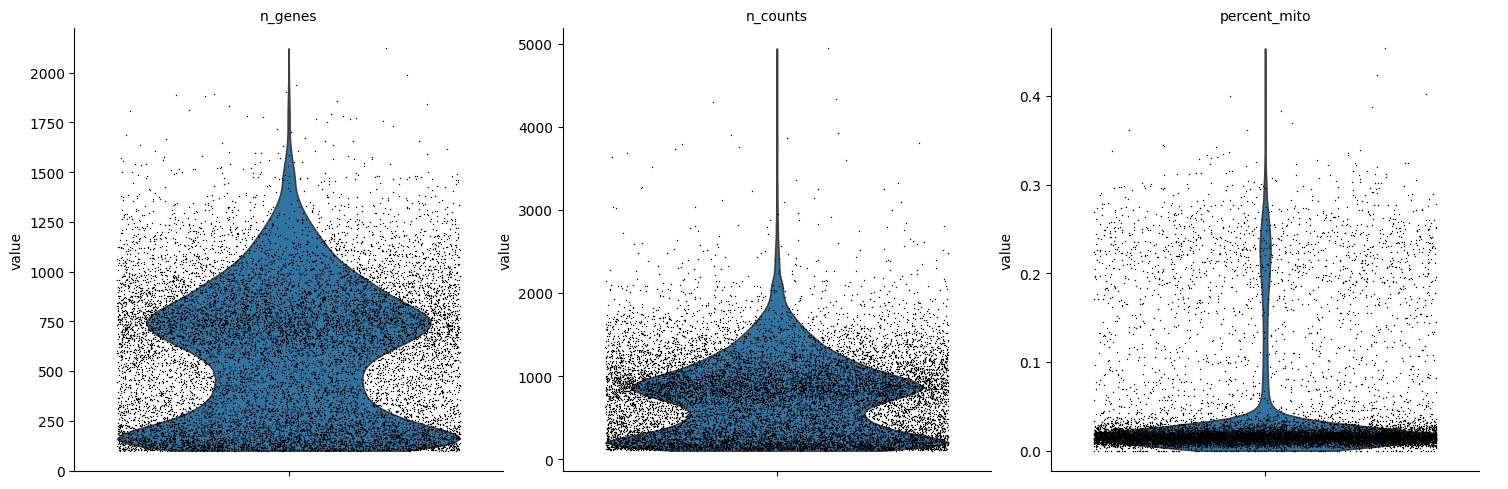

In [111]:
sc.pl.violin(adata_st, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

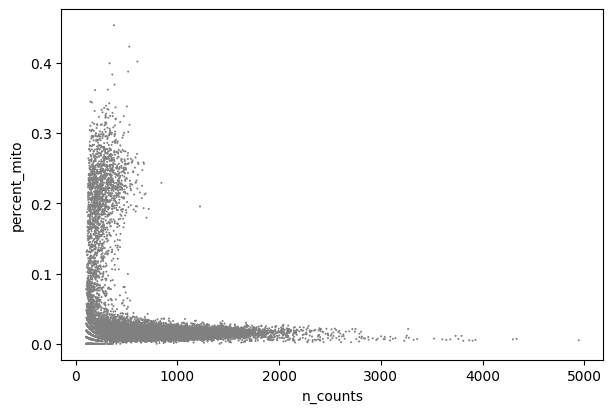

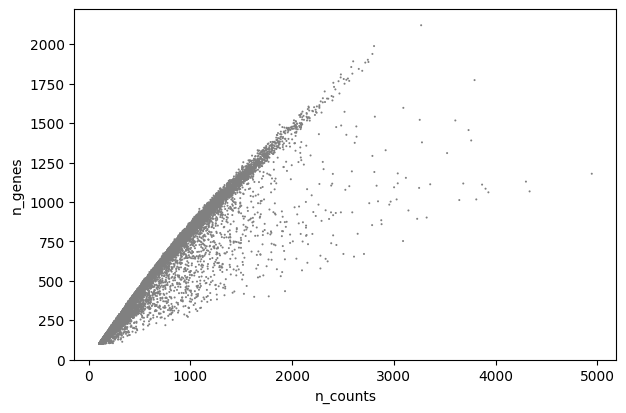

In [112]:
sc.pl.scatter(adata_st, x='n_counts', y='percent_mito')
sc.pl.scatter(adata_st, x='n_counts', y='n_genes')

In [113]:
adata_st = adata_st[adata_st.obs.n_genes < 2500, :]
adata_st = adata_st[adata_st.obs.percent_mito < 0.05, :]
adata_st

View of AnnData object with n_obs × n_vars = 12123 × 18426
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    obsm: 'spatial'

In [114]:
adata_sc = sc.read_h5ad('/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/zhongli_ref_202401203_mannually_woDoublet.h5ad')
# adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/rctd_outputs/mouse_lymphnode_slideseq/zhongli_ref_202401203_mannually_woDoublet.h5ad')
adata_sc

AnnData object with n_obs × n_vars = 15948 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'leiden_res_1.00', 'leiden_res_1.50', 'leiden_res_2.00'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [115]:
adata_sc.obs['cell_type'].value_counts()

cell_type
B            8158
Resting T    3493
CD8+ T       2631
DC            520
Treg          416
Tfh           376
Th2           188
NK             86
gd T           80
Name: count, dtype: int64

In [116]:
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

squidpy==1.6.5
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers['organ'].unique()

<StringArray>
[             'Brain',       'Reproductive',        'Vasculature',
   'Olfactory system',              'Liver',         'Epithelium',
  'Connective tissue',               'Bone',           'GI tract',
    'Skeletal muscle',      'Smooth muscle',             'Kidney',
              'Heart',      'Immune system',              'Lungs',
              'Blood',      'Mammary gland',               'Skin',
                'Eye',            'Thyroid',             'Zygote',
           'Pancreas',           'Placenta',    'Urinary bladder',
 'Parathyroid glands',        'Oral cavity']
Length: 26, dtype: string

In [118]:
immune_markers = markers[markers['organ'] == 'Immune system']
immune_markers = set(immune_markers['genesymbol'].values)
len(immune_markers)

144

In [119]:
# Annotations without hv_genes looks more biologically accurate

# sc.tl.rank_genes_groups(adata_sc, groupby="cell_type", use_raw=False)
# hv_markers = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# hv_markers = list(np.unique(hv_markers.melt().value.values))
# len(hv_markers)

In [120]:
# markers = list(set(hv_markers) | set(immune_markers))
markers = immune_markers
len(markers)

144

In [121]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

138 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
14021 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [122]:
%%time 

ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="clusters",
    cluster_label='cell_type', 
    density_prior='rna_count_based',
    num_epochs=500,
    # device="cuda:0",
    # device='cpu',
    device='mps'
)

Allocate tensors for mapping.
Begin training with 138 genes and rna_count_based density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.178, KL reg: 0.358
Score: 0.375, KL reg: 0.002
Score: 0.376, KL reg: 0.002
Score: 0.377, KL reg: 0.002
Score: 0.377, KL reg: 0.002


Saving results..


CPU times: user 3.19 s, sys: 1.4 s, total: 4.59 s
Wall time: 5.14 s


In [123]:
adata_st

AnnData object with n_obs × n_vars = 12123 × 18423
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'percent_mito', 'n_counts', 'uniform_density', 'rna_count_based_density'
    var: 'gene_ids', 'feature_types', 'n_cells', 'sparsity'
    uns: 'training_genes', 'overlap_genes'
    obsm: 'spatial'

In [124]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_type")

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


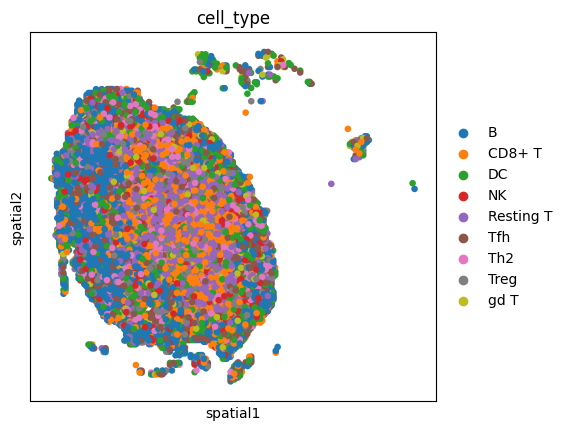

In [125]:
adata_st.obs['cell_type'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

sc.pl.spatial(adata_st, color=['cell_type'], spot_size=60)

In [126]:
adata_st.obs['cell_type'].value_counts()

cell_type
B            2567
Resting T    2052
CD8+ T       1869
DC           1498
Tfh          1386
Th2           885
Treg          881
NK            693
gd T          292
Name: count, dtype: int64

In [127]:
adata_st.X.min(), adata_st.X.max()

(0.0, 2243.0)

In [128]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels


In [129]:
clean_up_adata(adata_st, ['cell_type', 'spatial'])

# rename since no longer using the reference gex
ad_ge = adata_st

In [130]:
ad_ge.obs['cell_type'] = ad_ge.obs['cell_type'].astype('category')
ad_ge.obs['cell_type_int'] = ad_ge.obs['cell_type'].apply(
    lambda x: encode_labels(ad_ge.obs['cell_type'], reverse_dict=True)[x])

ad_ge


AnnData object with n_obs × n_vars = 12123 × 18423
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'tangram_ct_pred'

In [131]:
ad_ge.var_names = ad_ge.var_names.str.capitalize()

In [132]:
ad_ge.layers['raw_count'] = ad_ge.X.copy()

In [133]:
ad_ge

AnnData object with n_obs × n_vars = 12123 × 18423
    obs: 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'tangram_ct_pred'
    layers: 'raw_count'

In [134]:
ad_ge.write(f'/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs/mouse_lymphKO{sample}_visiumHD.h5ad')


### QC Metrics

In [ ]:
# tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs'
tmp_dir = '/Users/allywang/Desktop/work/S2025/SpaceOracle/visiumHD_lymph/tangram_outputs'

adata_1 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO1_visiumHD.h5ad')
adata_2 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO2_visiumHD.h5ad')
adata_3 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO3_visiumHD.h5ad')
adata_4 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO4_visiumHD.h5ad')

adata_1, adata_2, adata_3, adata_4

(AnnData object with n_obs × n_vars = 63380 × 18970
     obs: 'cell_type', 'cell_type_int'
     obsm: 'spatial', 'tangram_ct_pred'
     layers: 'raw_count',
 AnnData object with n_obs × n_vars = 56214 × 18992
     obs: 'cell_type', 'cell_type_int'
     obsm: 'spatial', 'tangram_ct_pred'
     layers: 'raw_count',
 AnnData object with n_obs × n_vars = 48980 × 18980
     obs: 'cell_type', 'cell_type_int'
     obsm: 'spatial', 'tangram_ct_pred'
     layers: 'raw_count',
 AnnData object with n_obs × n_vars = 12123 × 18423
     obs: 'cell_type', 'cell_type_int'
     obsm: 'spatial', 'tangram_ct_pred'
     layers: 'raw_count')

In [136]:
adata = sc.concat(
    [adata_1, adata_2, adata_3, adata_4], 
    join='outer', label='sample', 
    keys=['adata_1', 'adata_2', 'adata_3', 'adata_4']
)
adata

AnnData object with n_obs × n_vars = 180697 × 19008
    obs: 'cell_type', 'cell_type_int', 'sample'
    obsm: 'spatial', 'tangram_ct_pred'
    layers: 'raw_count'

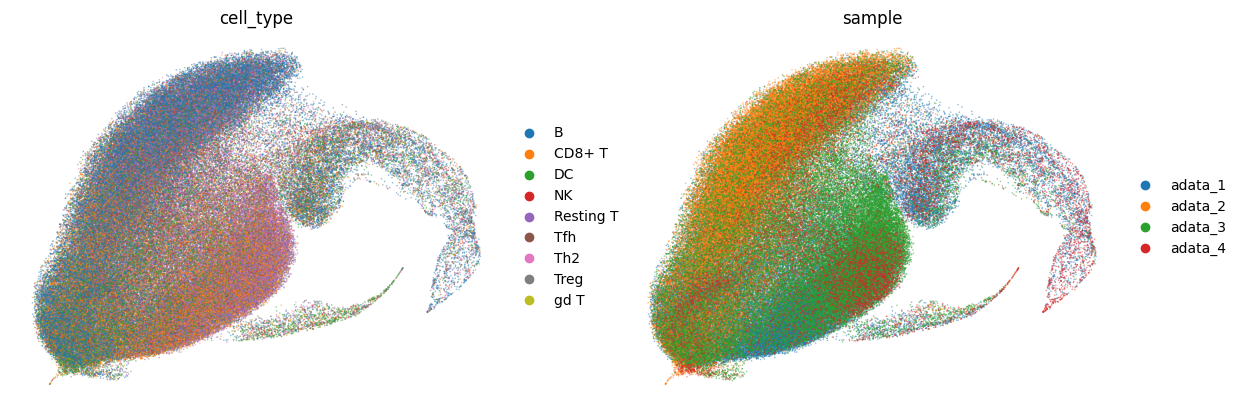

CPU times: user 4min 9s, sys: 4min 12s, total: 8min 21s
Wall time: 1min 50s


In [137]:
%%time
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'sample'], size=5, frameon=False, alpha=0.5)

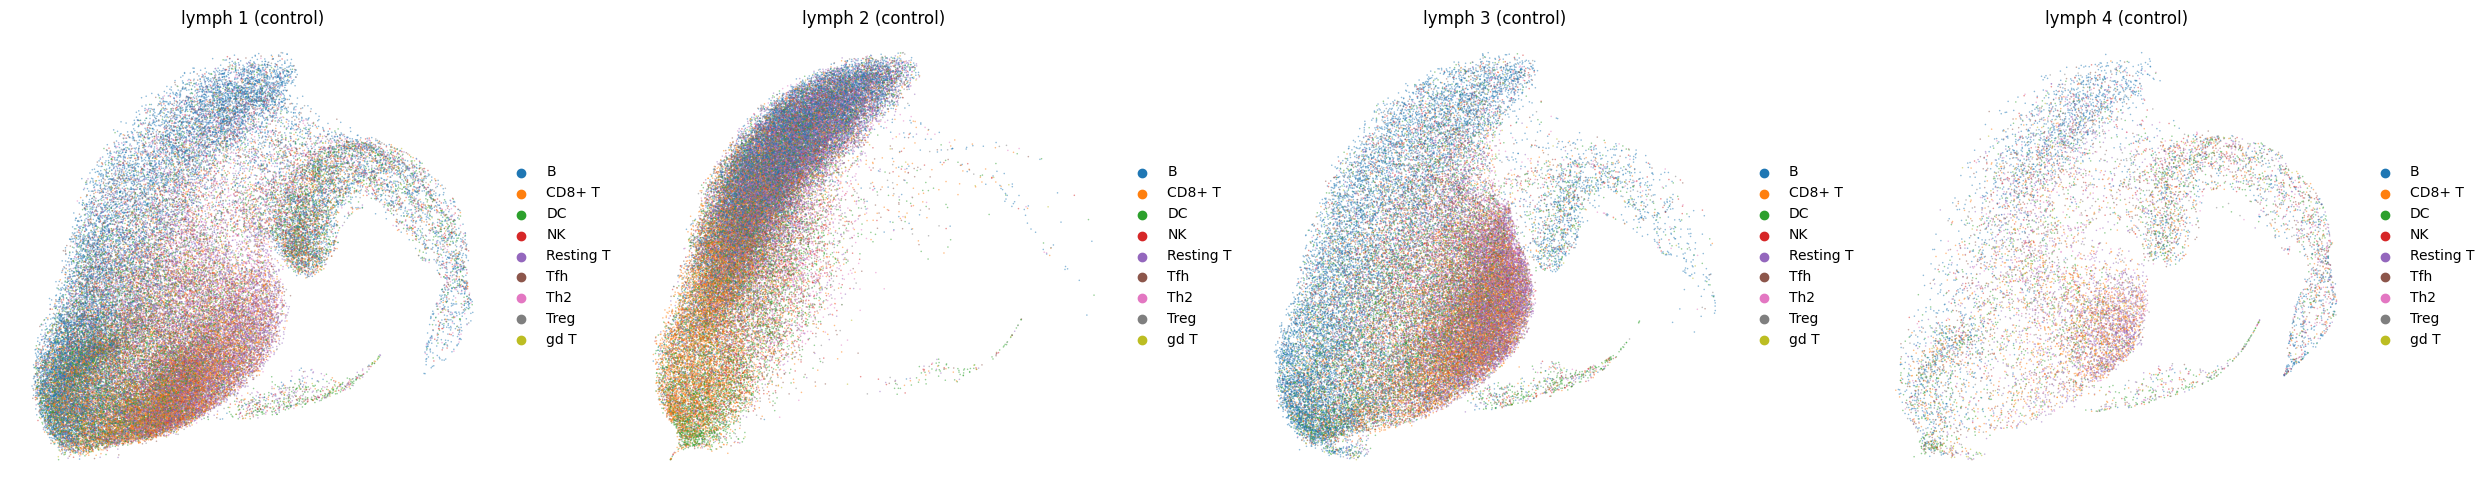

In [138]:
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
for i, sample in enumerate(adata.obs['sample'].unique()):
    sc.pl.umap(
        adata[adata.obs['sample'] == sample], 
        color=['cell_type'], 
        ax=axs[i], 
        title=f'lymph {i+1} (control)', 
        size=5, frameon=False, alpha=0.5,
        show=False
    )
plt.tight_layout()

In [139]:
adata.X = adata.layers['raw_count'].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['normalized_count'] = adata.X.copy()

In [140]:
def plot_visualizations(adata, ax_hist, ax_spatial, lymph_id, gene='Ccl4'):
    gex = adata[:, gene].to_df(layer='normalized_count').values.flatten()  
    ax_hist.hist(gex, bins=50, color='c', edgecolor='black')
    ax_hist.semilogy()
    ax_hist.set_title(f'Lymph {lymph_id} {gene} Expression')
    ax_hist.set_xlabel(f'{gene} Expression')
    ax_hist.set_ylabel('Number of Cells')

    sc.pl.spatial(adata, color=gene, spot_size=50, cmap='viridis', ax=ax_spatial, show=False)

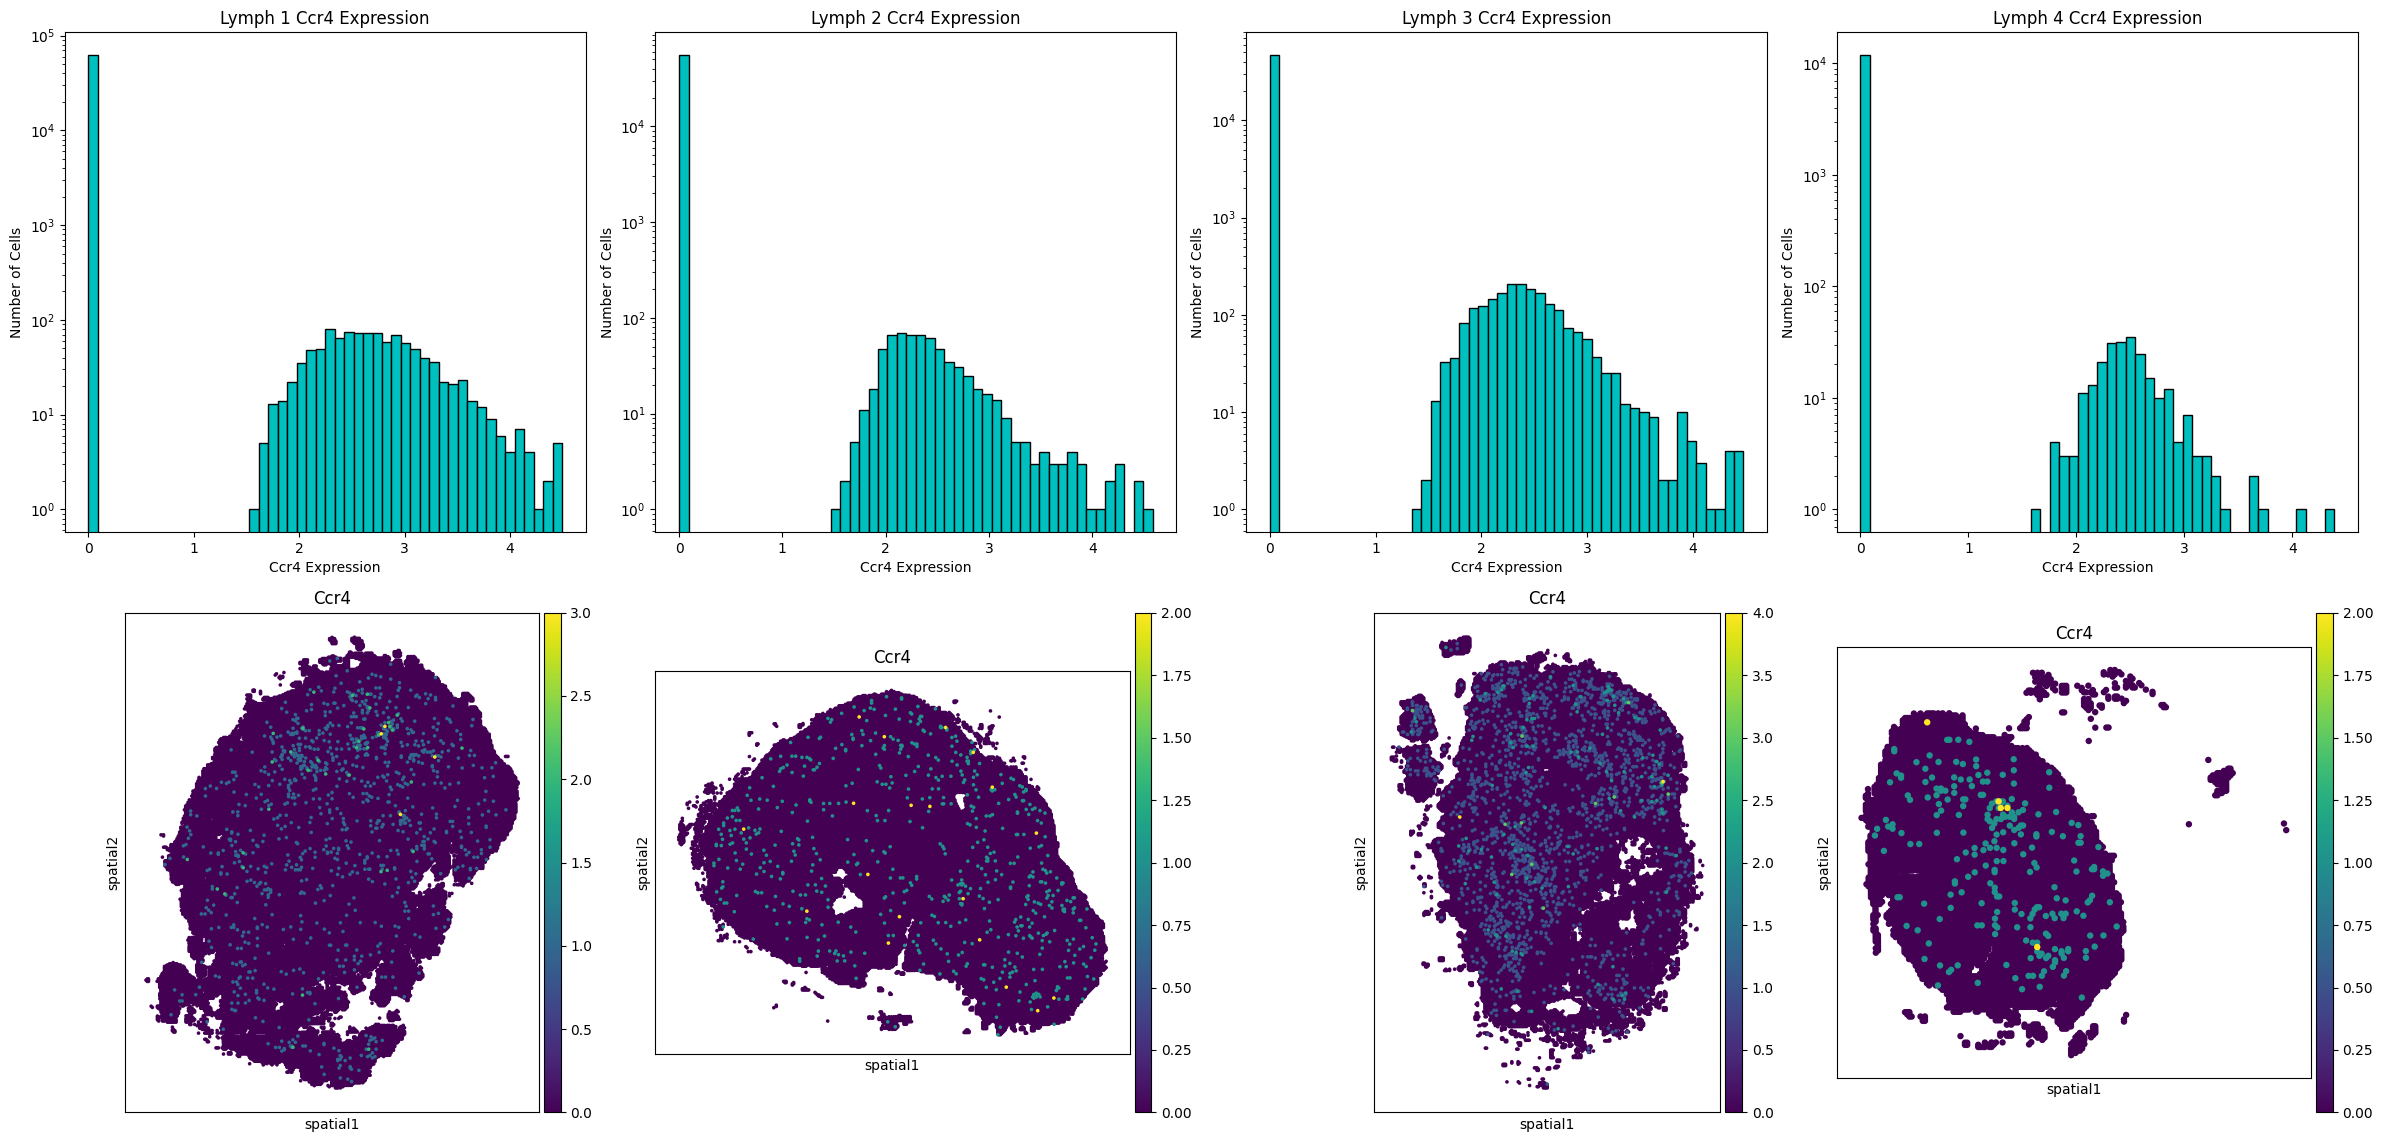

In [147]:
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for i, sample in enumerate(adata.obs['sample'].unique()):
    plot_visualizations(
        adata[adata.obs['sample'] == sample], 
        axs[0, i], 
        axs[1, i], 
        lymph_id=i+1,
        gene='Ccr4'
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [142]:
adata.X = adata.layers['raw_count'].copy()

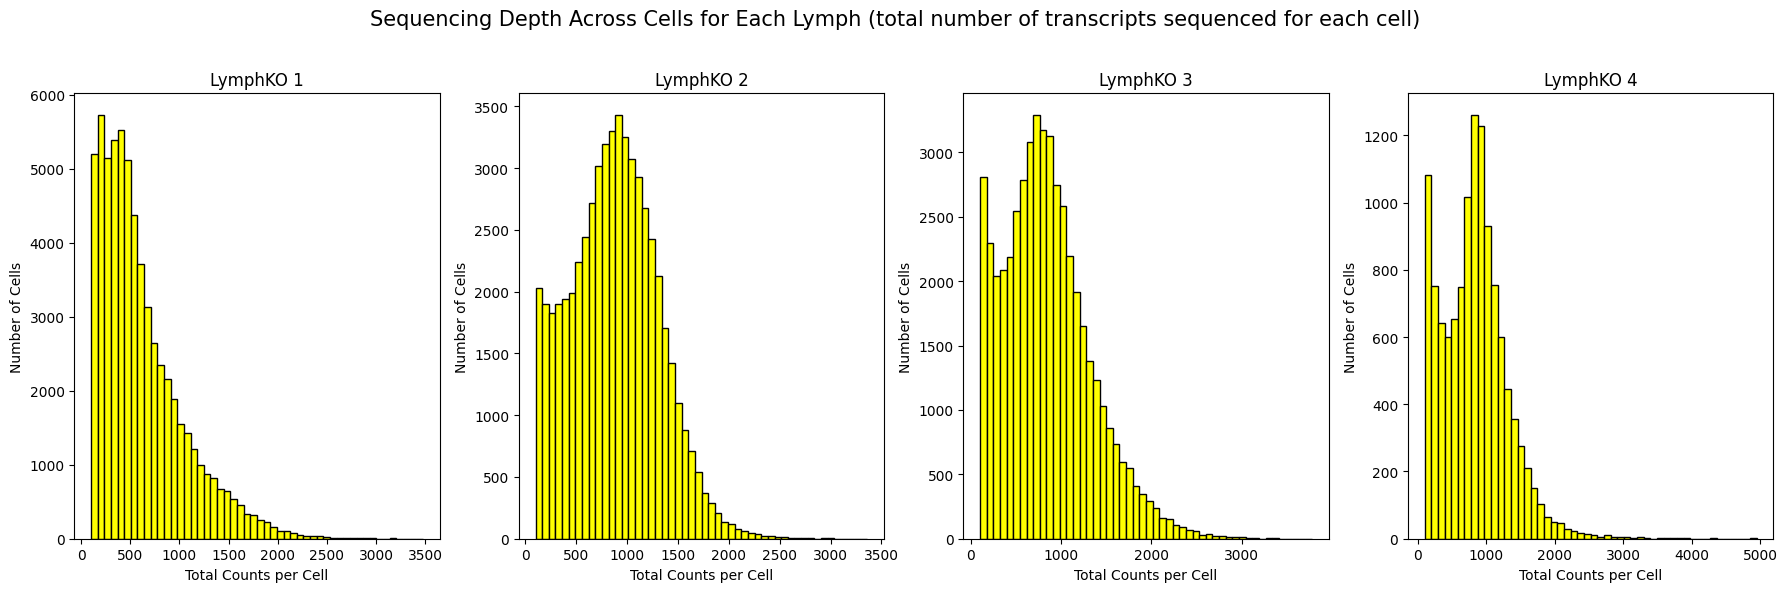

In [143]:
# Plot total number of transcripts sequenced for each cell

fig, axs = plt.subplots(1, 4, figsize=(18, 6)) 
fig.suptitle('Sequencing Depth Across Cells for Each Lymph (total number of transcripts sequenced for each cell)', fontsize=15)

adata.obs['total_counts'] = adata.X.toarray().sum(axis=1).flatten()

for i, sample in enumerate(adata.obs['sample'].unique()):
    subset = adata[adata.obs['sample'] == sample]

    axs[i].hist(subset.obs['total_counts'], bins=50, color='yellow', edgecolor='black')
    axs[i].set_title(f'LymphKO {i+1}')
    axs[i].set_xlabel('Total Counts per Cell')
    axs[i].set_ylabel('Number of Cells')

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


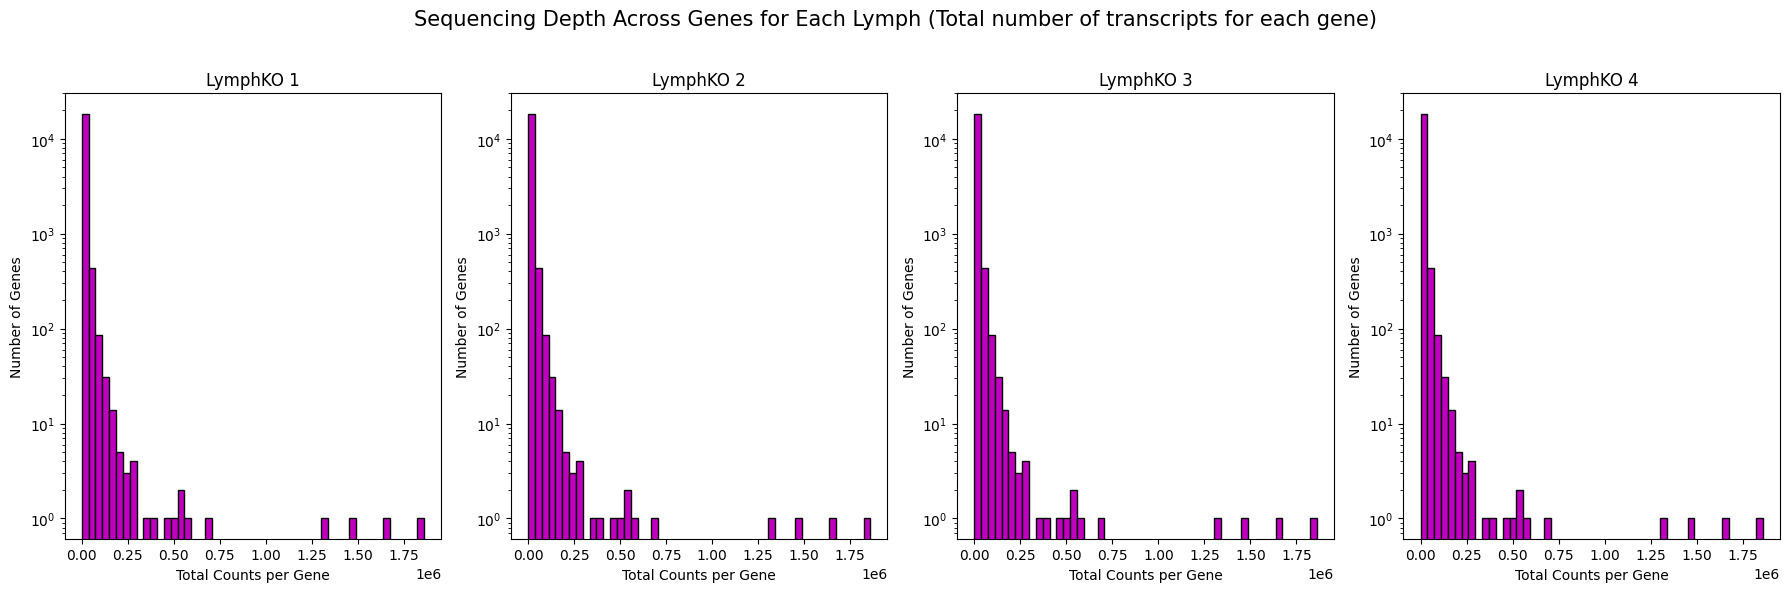

In [145]:

fig, axs = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns
fig.suptitle('Sequencing Depth Across Genes for Each Lymph (Total number of transcripts for each gene)', fontsize=15)

adata.var['total_counts_per_gene'] = adata.X.toarray().sum(axis=0).flatten()

for i, sample in enumerate(adata.obs['sample'].unique()):

    subset = adata[adata.obs['sample'] == sample]

    axs[i].hist(subset.var['total_counts_per_gene'], bins=50, color='m', edgecolor='black')
    axs[i].set_title(f'LymphKO {i+1}')
    axs[i].set_xlabel('Total Counts per Gene')
    axs[i].set_ylabel('Number of Genes')
    axs[i].semilogy() 

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()


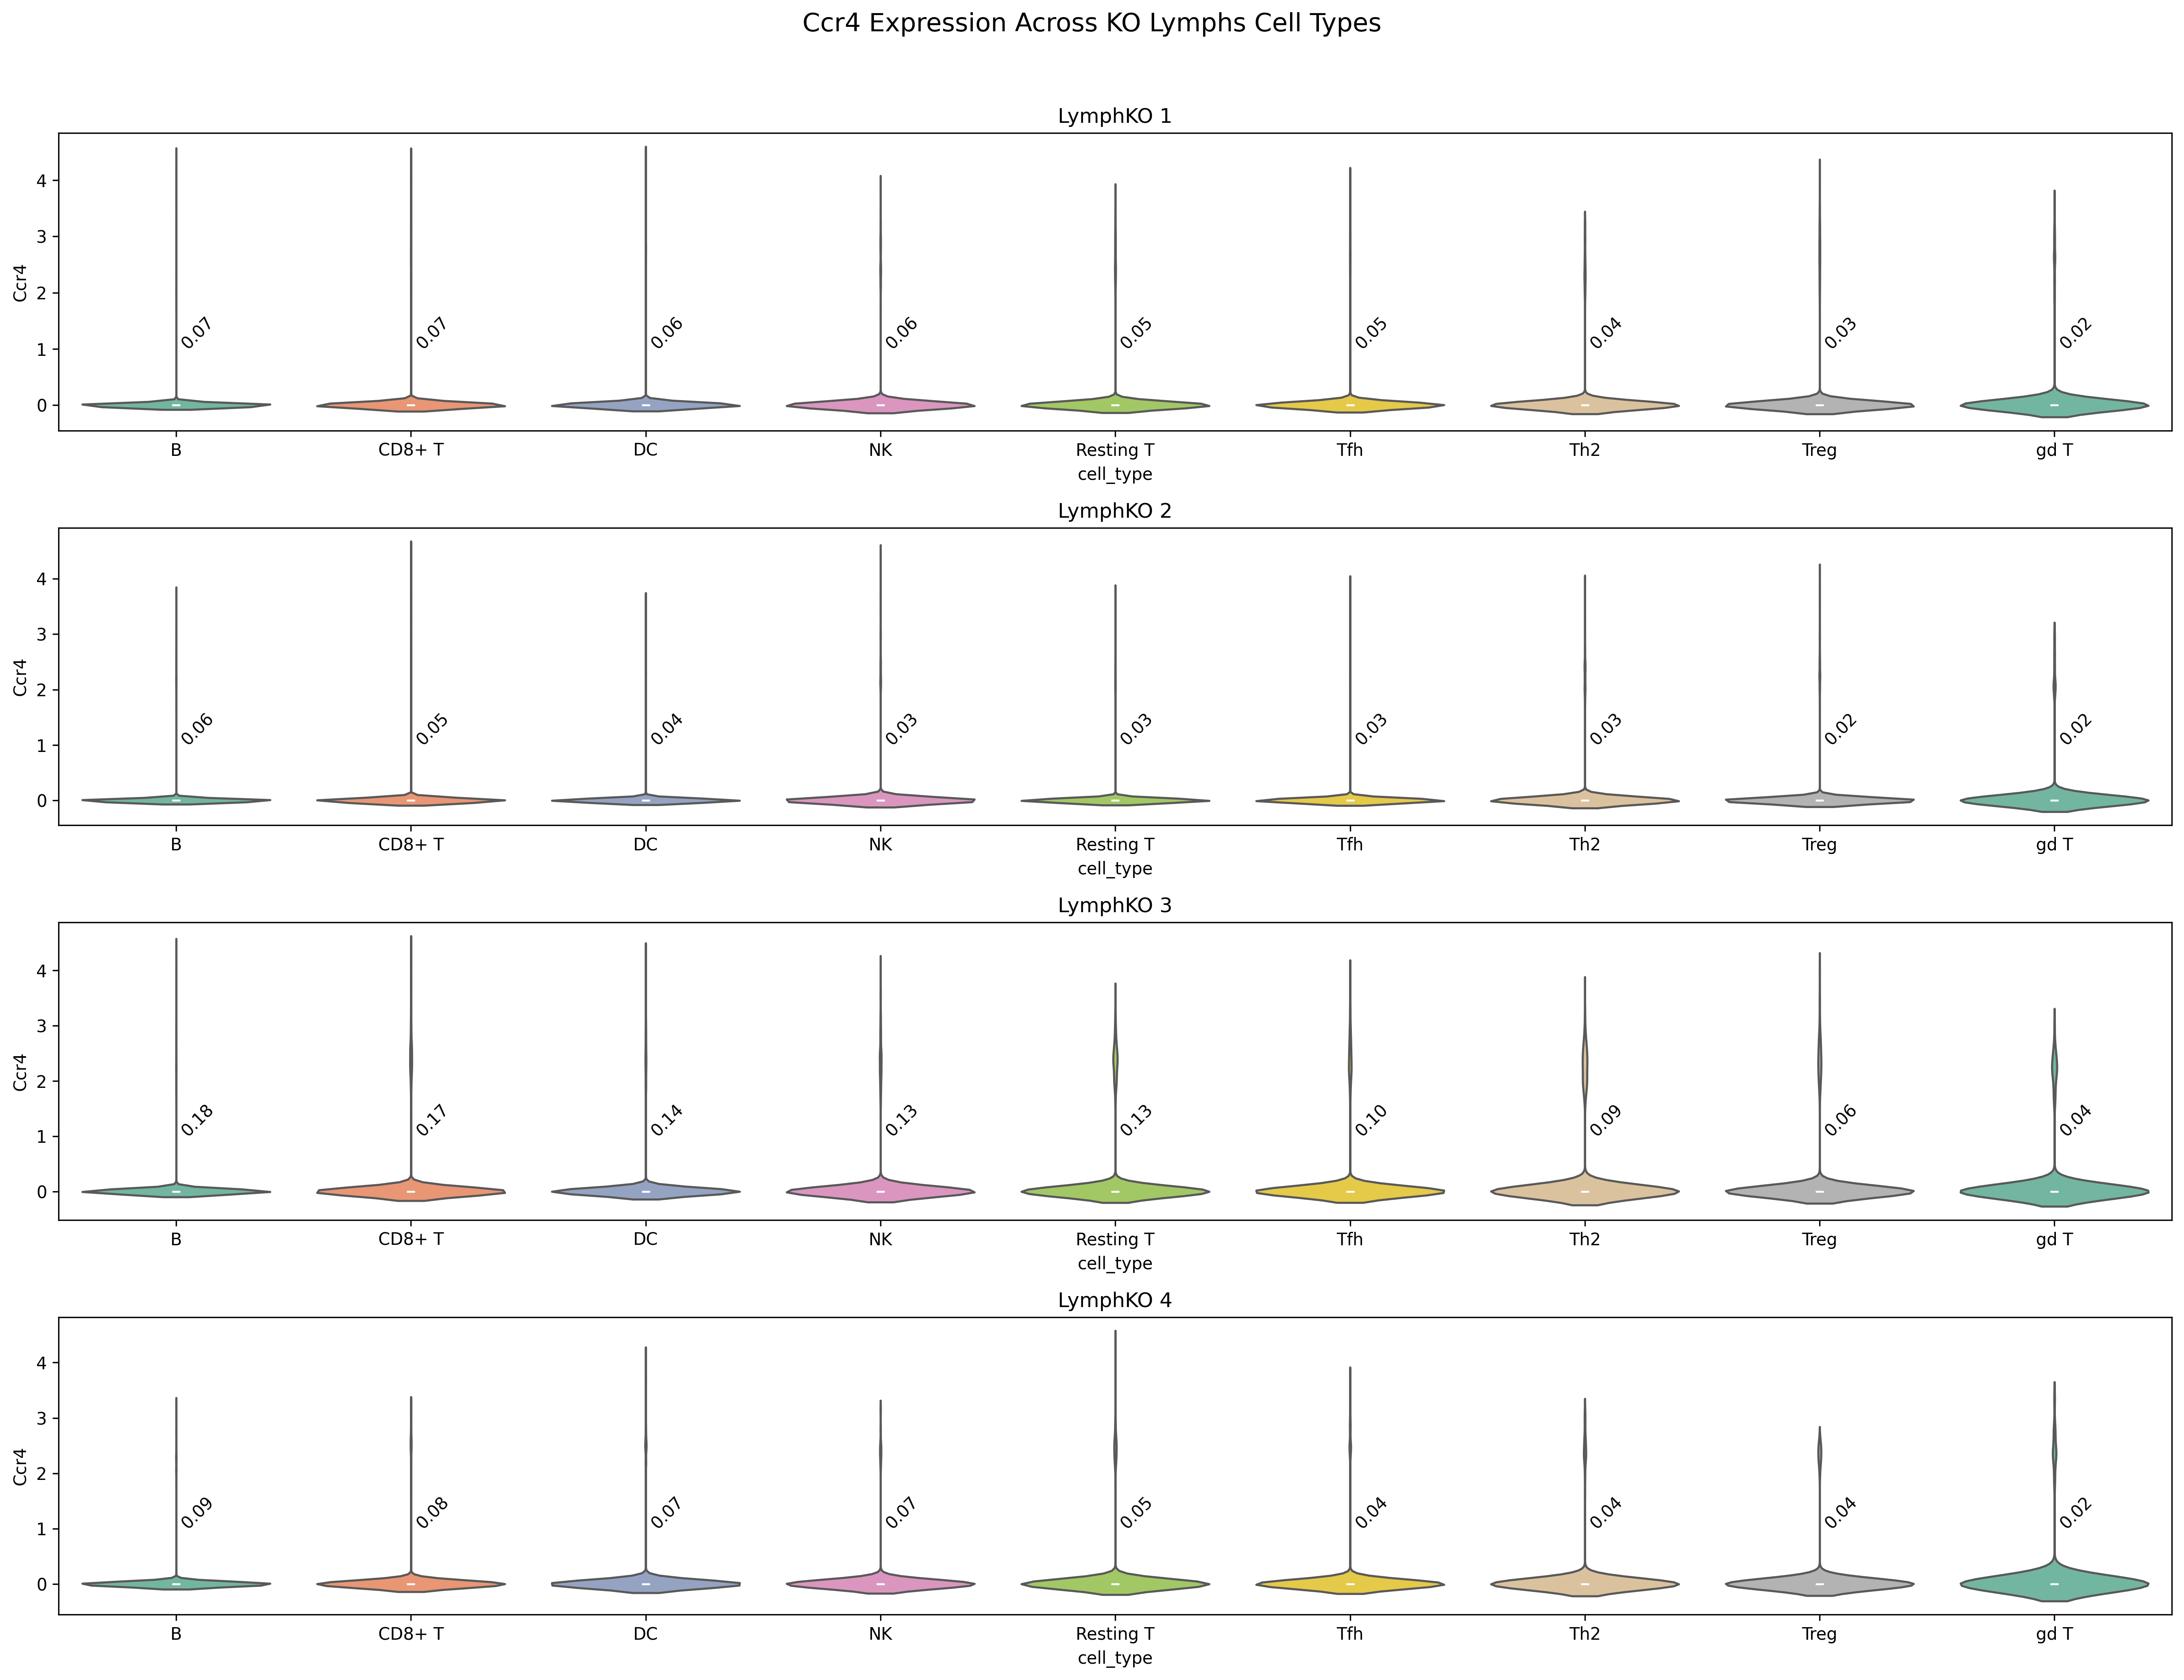

In [187]:
fig, axs = plt.subplots(4, figsize=(18, 14), dpi=300) 

for i, sample in enumerate(adata.obs['sample'].unique()):
    
    adata_subset = adata[adata.obs['sample'] == sample]
    exp = adata_subset[:, 'Ccr4'].to_df(layer='normalized_count')
    exp = pd.concat([exp, adata_subset.obs['cell_type']], axis=1)

    sns.violinplot(
        x='cell_type', y='Ccr4', data=exp, ax=axs[i], palette='Set2'
    )

    avgs = exp.groupby('cell_type').mean().sort_values(by='Ccr4', ascending=False)
    for j, celltype in enumerate(avgs.index):
        axs[i].text(
            j+0.01, 1, f'{avgs.loc[celltype, "Ccr4"]:.2f}', 
            rotation=45, fontsize=10
        )


    axs[i].set_title(f'LymphKO {i+1}')

plt.suptitle('Ccr4 Expression Across KO Lymphs Cell Types', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])

### Examine expression

In [44]:
tmp_dir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025'

adata_1 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph1_ctrl_visiumHD.h5ad')
adata_2 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph2_ctrl_visiumHD.h5ad')
adata_3 = sc.read_h5ad(f'{tmp_dir}/mouse_lymph3_ctrl_visiumHD.h5ad')

adata_1, adata_2, adata_3

(AnnData object with n_obs × n_vars = 48988 × 3204
     obs: 'cell_type', 'cell_type_int', 'sample'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cell_type_colors', 'hvg', 'log1p'
     obsm: 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
     layers: 'imputed_count', 'normalized_count', 'raw_count',
 AnnData object with n_obs × n_vars = 47031 × 3204
     obs: 'cell_type', 'cell_type_int', 'sample'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cell_type_colors', 'hvg', 'log1p'
     obsm: 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
     layers: 'imputed_count', 'normalized_count', 'raw_count',
 AnnData object with n_obs × n_vars = 40524 × 3204
     obs: 'cell_type', 'cell_type_int', 'sample'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cell_type_colors', 'hvg', 'log1p'
     obsm: 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
     layer

In [45]:
adata = sc.concat(
    [adata_1, adata_2, adata_3], 
    join='outer', label='sample', 
    keys=['adata_1', 'adata_2', 'adata_3']
)
adata

AnnData object with n_obs × n_vars = 136543 × 3204
    obs: 'cell_type', 'cell_type_int', 'sample'
    obsm: 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [46]:
def get_norm_layer(adata):
    adata.X = adata.layers['raw_count'].copy()

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata.layers['normalized_count'] = adata.X.copy()
    return adata

adata= get_norm_layer(adata)

In [47]:
def plot_expression_comparison(dataframes, axes, titles, suptitle):
    """
    Plots scatter plots for multiple dataframes comparing two axes.

    Parameters:
    - dataframes: list of pandas DataFrames
    - axes: list of two strings, the column names to compare (e.g., ['Ccr4', 'Prdm1'])
    - titles: list of titles for each subplot
    """
    num_plots = len(dataframes)
    fig, axs = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6), dpi=300)

    for i, (df, title) in enumerate(zip(dataframes, titles)):
        highlight = (df[axes[0]] > 1) & (df[axes[1]] > 1)
        n_pos_cells = highlight.sum()
        n_other_cells = len(df) - highlight.sum()
        axs[i].scatter(
            x=df.loc[highlight, axes[0]],
            y=df.loc[highlight, axes[1]],
            s=30, c='red', edgecolor='black', alpha=0.8, label=f'{axes[0]}+ {axes[1]}+ | {n_pos_cells} cells'
        )
        axs[i].scatter(
            x=df.loc[~highlight, axes[0]],
            y=df.loc[~highlight, axes[1]],
            s=30, c='blue', edgecolor='black', alpha=0.9, label=f'Other cells | {n_other_cells} cells'
        )
        axs[i].axvline(x=0.5, color='black', linestyle='--', linewidth=1, alpha=0.8)
        axs[i].axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.8)
        axs[i].set_xlabel(f'{axes[0]} Expression')
        axs[i].set_ylabel(f'{axes[1]} Expression')
        axs[i].set_title(f'{title} ({n_pos_cells/ len(df) * 100:.2f}%)')
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].legend()

    plt.suptitle(suptitle, fontsize=16)
    plt.tight_layout()
    plt.show()

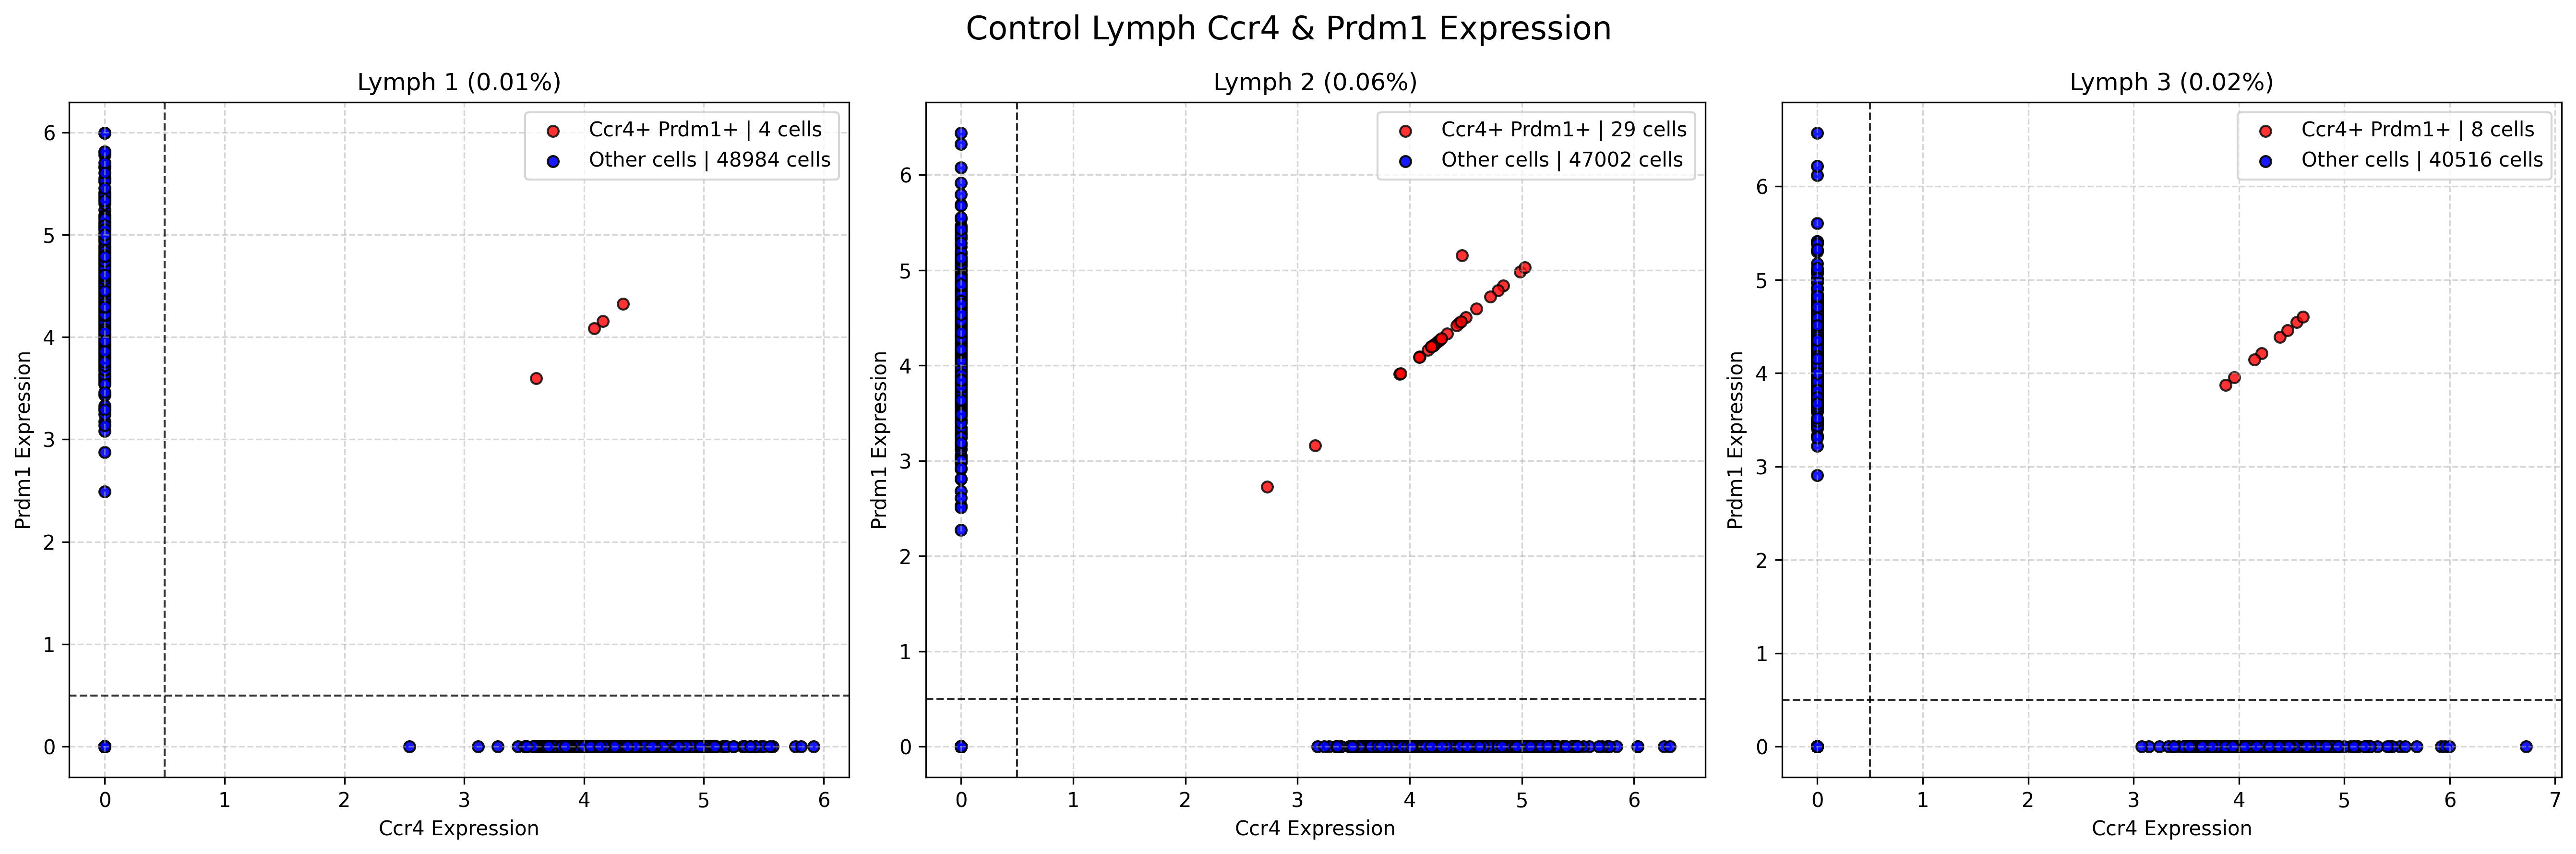

In [48]:
axes= ['Ccr4', 'Prdm1']
titles = ['Lymph 1', 'Lymph 2', 'Lymph 3']
dataframes = [
    adata[adata.obs['sample'] == subset, axes].to_df(layer='normalized_count') 
    for subset in ['adata_1', 'adata_2', 'adata_3']
]

plot_expression_comparison(
    dataframes, 
    axes=axes, 
    titles=titles,
    suptitle='Control Lymph Ccr4 & Prdm1 Expression'
)

In [ ]:
tmp_dir = '/ix3/djishnu/alw399/visiumHD_lymph/tangram_outputs'

adata_1 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO1_visiumHD.h5ad')
adata_2 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO2_visiumHD.h5ad')
adata_3 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO3_visiumHD.h5ad')
adata_4 = sc.read_h5ad(f'{tmp_dir}/mouse_lymphKO3_visiumHD.h5ad')

adata = sc.concat(
    [adata_1, adata_2, adata_3, adata_4], 
    join='outer', label='sample', 
    keys=['adata_1', 'adata_2', 'adata_3', 'adata_4']
)

adata = get_norm_layer(adata)
adata


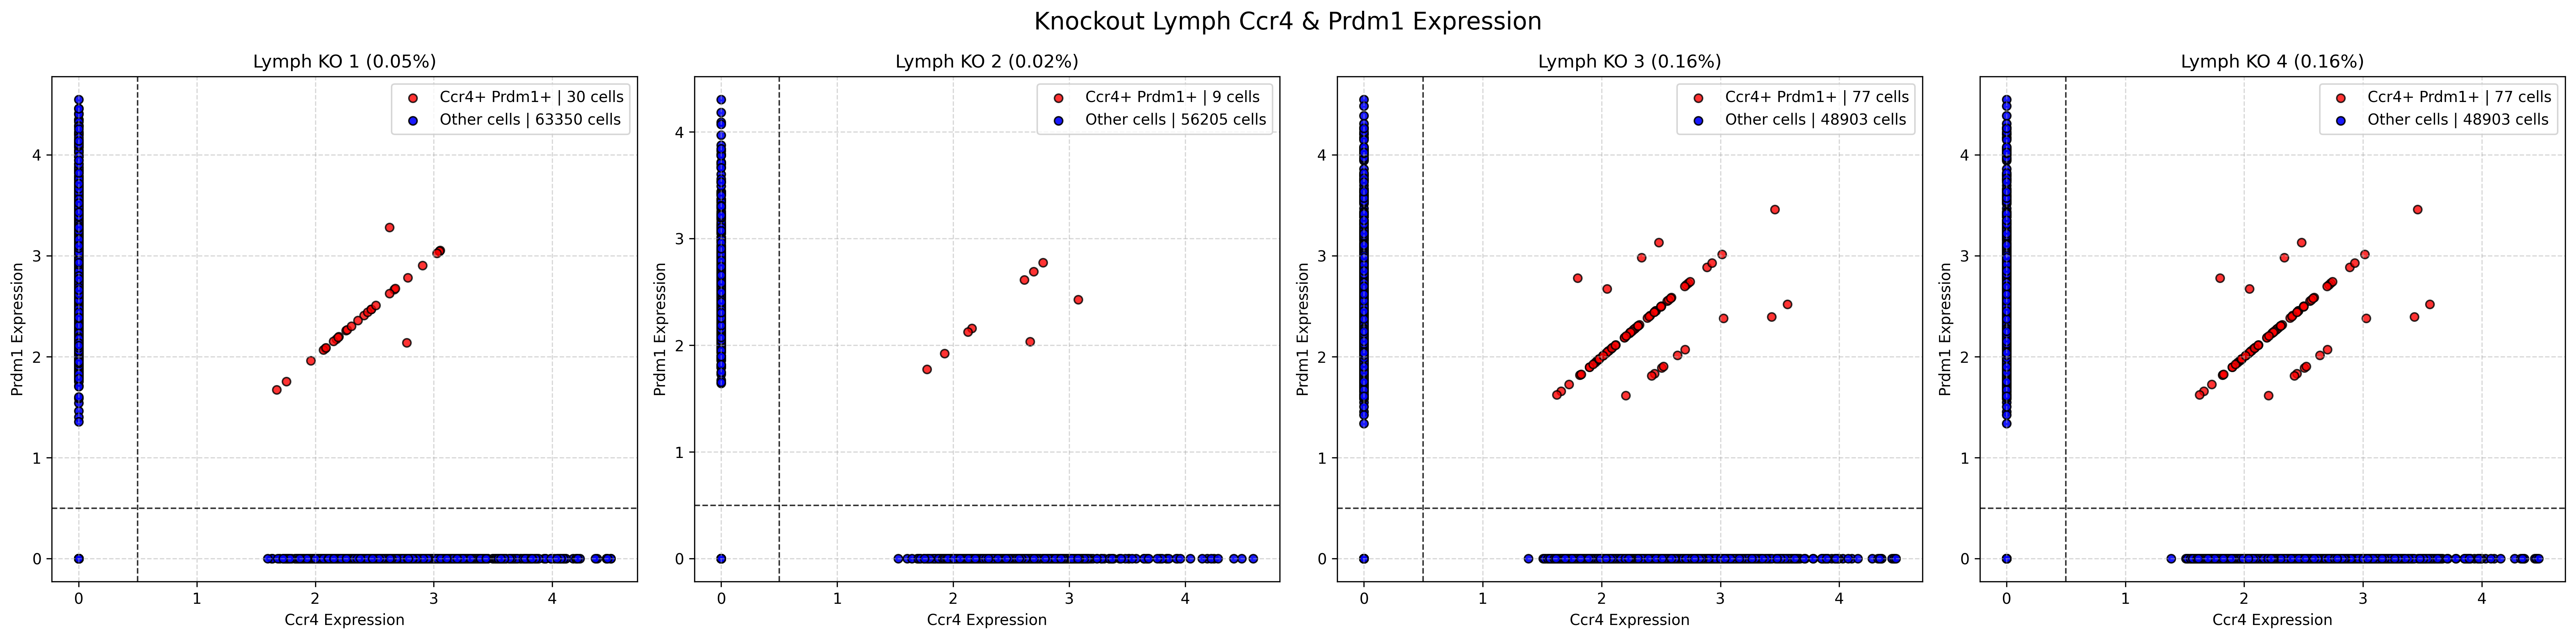

In [43]:
axes= ['Ccr4', 'Prdm1']
titles = ['Lymph KO 1', 'Lymph KO 2', 'Lymph KO 3', 'Lymph KO 4']
dataframes = [
    adata[adata.obs['sample'] == subset, axes].to_df(layer='normalized_count') 
    for subset in ['adata_1', 'adata_2', 'adata_3', 'adata_4']
]

plot_expression_comparison(
    dataframes, 
    axes=axes, 
    titles=titles,
    suptitle='Knockout Lymph Ccr4 & Prdm1 Expression'
)